In [1]:
import numpy as np
from random import randint as rand
from matplotlib import pyplot as plt

In [2]:
import config
config.configure_imports()

from Map import Map
from Node import Node
from Change import Change
from LPAStar import LPAStar
from DStar import DStar
from DStarLite import DStarLite
from a_star import a_star

from visualizer import *
from data_parser import *

In [3]:
lak105d_filename = '../data/lak105d.map'
lak105d_scen_filename = '../data/lak105d.map.scen'
den204d_filename = '../data/den204d.map'
den204d_scen_filename = '../data/den204d.map.scen'
den312d_filename = '../data/den312d.map'
den312d_scen_filename = '../data/den312d.map.scen'
Paris_256_filename = '../data/Paris_1_256.map'

In [4]:
def compare_lpa_a_star(
    map_filename,
    scen_filename,
    n_tasks = None,
    n_changes = 10,
    changes_range = (0.0, 1.0)
):
    random.seed(123)

    lpa_visiteds = []
    a_star_visiteds = []
    for start_i, start_j, goal_i, goal_j, _ in read_map_scen(scen_filename, n_tasks):
        _map, _map_a = Map(), Map()
        _map.read_from_string(*read_map(map_filename))
        _map_a.read_from_string(*read_map(map_filename))

        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)

        for _ in range(n_changes):
            true_result, a_star_visited = a_star(_map_a, start, finish, return_visited=True)
            if true_result == -1:
                break

            lpa_star = LPAStar(_map, start, finish)
            lpa_path = lpa_star.greedy_path()

            if len(lpa_path) < 3:
                break

            range_start, range_end = changes_range
            rand_start, rand_end = int(len(lpa_path) * range_start) + 1, int(len(lpa_path) * range_end) - 1
            rand_start = min(rand_start, rand_end)
            index = rand(rand_start, rand_end)

            qi, qj = lpa_path[index].coordinates()

            lpa_visited = lpa_star.apply_changes([Change(0, qi, qj, True)])
            _map_a.apply_change(Change(0, qi, qj, True))

            lpa_visiteds.append(len(lpa_visited))
            a_star_visiteds.append(len(a_star_visited))

    return lpa_visiteds, a_star_visiteds

In [5]:
def compute_diff(lpa_v, a_v):
    s = 0
    for a, b, in zip(lpa_v, a_v):
        s += (b - a) / b
    return s / len(a_v)

In [6]:
def draw_lpa_vs_a_star(lpa_v, a_v, title):
    indices = np.array(a_v).argsort()
    lpa_v = np.array(lpa_v)[indices]
    a_v = np.array(a_v)[indices]
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.scatter(list(range(len(a_v))), lpa_v, label='LPA*')
    ax.scatter(list(range(len(a_v))), a_v, label='A*')
    ax.set_xlabel('number of test')
    ax.set_ylabel('reopened vertices')
    ax.set_title(title)
    ax.legend()
    plt.show()

In [7]:
lpa_lak_v, a_lak_v = compare_lpa_a_star(lak105d_filename, lak105d_scen_filename)

In [8]:
compute_diff(lpa_lak_v, a_lak_v)

0.6140036190876427

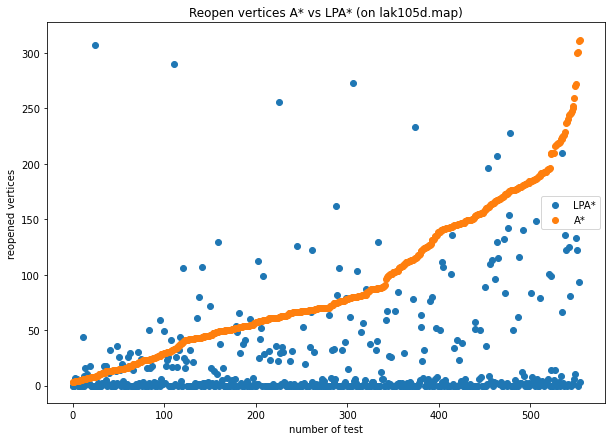

In [9]:
draw_lpa_vs_a_star(lpa_lak_v, a_lak_v, 'Reopen vertices A* vs LPA* (on lak105d.map)')

In [10]:
lpa_lak_v_st, a_lak_v_st = compare_lpa_a_star(lak105d_filename, lak105d_scen_filename, changes_range = (0.0, 0.1))
lpa_lak_v_end, a_lak_v_end = compare_lpa_a_star(lak105d_filename, lak105d_scen_filename, changes_range = (0.9, 1.0))

In [11]:
compute_diff(lpa_lak_v_st, a_lak_v_st)

0.06666875008877907

In [12]:
compute_diff(lpa_lak_v_end, a_lak_v_end)

0.8487132591367165

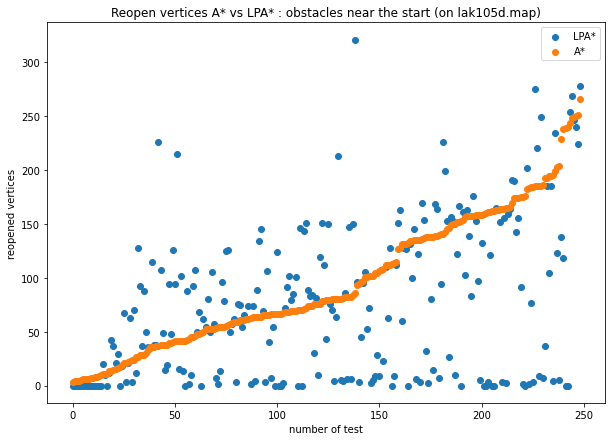

In [13]:
draw_lpa_vs_a_star(lpa_lak_v_st, a_lak_v_st, 'Reopen vertices A* vs LPA* : obstacles near the start (on lak105d.map)')

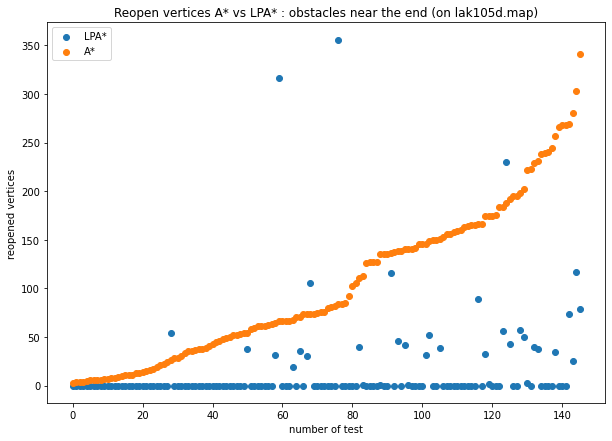

In [14]:
draw_lpa_vs_a_star(lpa_lak_v_end, a_lak_v_end, 'Reopen vertices A* vs LPA* : obstacles near the end (on lak105d.map)')

In [15]:
lpa_den_v, a_den_v = compare_lpa_a_star(den312d_filename, den312d_scen_filename, n_changes=10)

In [16]:
compute_diff(lpa_den_v, a_den_v)

0.29687283264602704

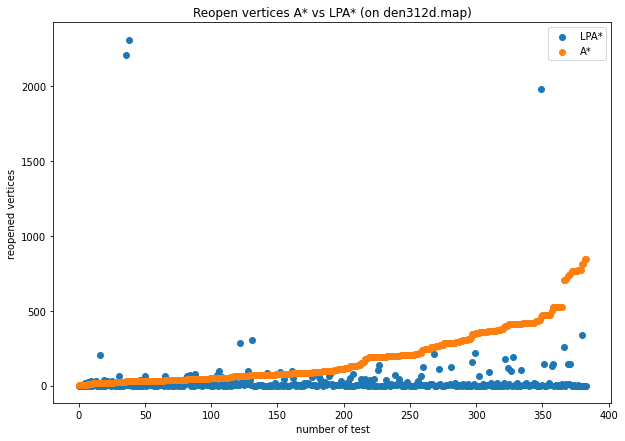

In [17]:
draw_lpa_vs_a_star(lpa_den_v, a_den_v, 'Reopen vertices A* vs LPA* (on den312d.map)')

In [18]:
def compare_d_star_lite_vision(map_filename, start, finish, max_vision = None):
    _map = Map()
    _map.read_from_string(*read_map(map_filename))

    results = []
    if max_vision is None:
        max_vision = max(_map._height, _map._width) - 1
    for vision_distance in range(1, max_vision + 1):
        d_star = DStarLite(_map, start, finish, vision_distance=vision_distance)
        d_star.run()
        results.append(len(d_star._path))

    return results

In [19]:
def draw_len_by_vision(len_by_vision, title):
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.plot(len_by_vision)
    ax.set_xlabel('vision radius')
    ax.set_ylabel('path length')
    ax.set_title(title)
    plt.show()

**den312.map**

In [20]:
len_by_vision_den312 = compare_d_star_lite_vision(den312d_filename, Node(8, 4), Node(51, 75))

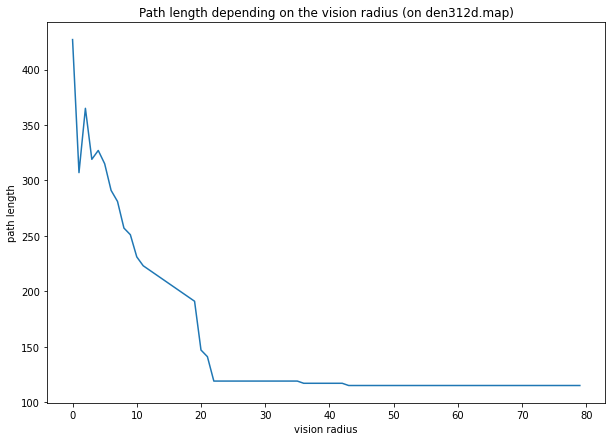

In [21]:
draw_len_by_vision(len_by_vision_den312, 'Path length depending on the vision radius (on den312d.map)')

**den204.map**

In [22]:
len_by_vision_den204 = compare_d_star_lite_vision(den204d_filename, Node(57, 13), Node(2, 58), max_vision=30)

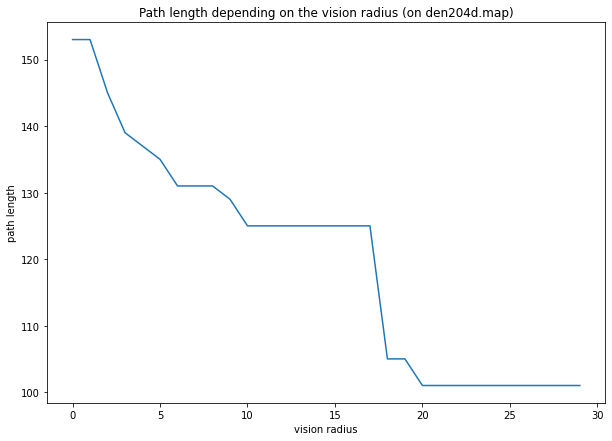

In [23]:
draw_len_by_vision(len_by_vision_den204, 'Path length depending on the vision radius (on den204d.map)')

In [24]:
def run_on(map_filename, scen_filename, algorithm, reversed_tasks = False):
    _map = Map()
    _map.read_from_string(*read_map(map_filename))

    add_counts, get_counts, pop_counts = [], [], []
    for start_i, start_j, goal_i, goal_j, _ in read_map_scen(scen_filename):
        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)
        if reversed_tasks:
            start = Node(start_j, start_i)
            finish = Node(goal_j, goal_i)

        algo = algorithm(_map, start, finish)
        algo.run()
        add_count, get_count, pop_count = algo.collect_open_stats()
        add_counts.append(add_count)
        get_counts.append(get_count)
        pop_counts.append(pop_count)

    return add_counts, get_counts, pop_counts

In [25]:
def draw_d_star_vs_lite_heap(d_star_data, d_star_lite_data, ylabel, title):
    indices = np.array(d_star_lite_data).argsort()
    d_star_data = np.array(d_star_data)[indices]
    d_star_lite_data = np.array(d_star_lite_data)[indices]
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.plot(d_star_data, label='D*')
    ax.plot(d_star_lite_data, label='D*lite')
    ax.set_xlabel('number of test')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    plt.show()

**lak105.map**

In [26]:
lak_ds_add, lak_ds_get, lak_ds_pop = run_on(lak105d_filename, lak105d_scen_filename, DStar)
lak_lt_add, lak_lt_get, lak_lt_pop = run_on(lak105d_filename, lak105d_scen_filename, DStarLite)

In [27]:
compute_diff(lak_lt_add, lak_ds_add)

0.5368867880539718

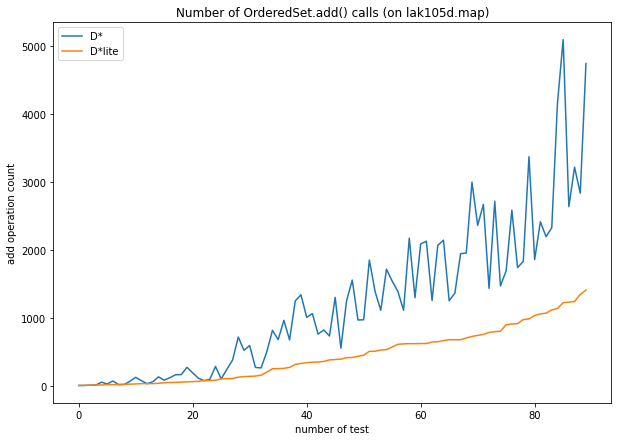

In [28]:
draw_d_star_vs_lite_heap(
    lak_ds_add, lak_lt_add,
    'add operation count', 'Number of OrderedSet.add() calls (on lak105d.map)'
)

In [29]:
compute_diff(lak_lt_pop, lak_ds_pop)

0.5579885521702952

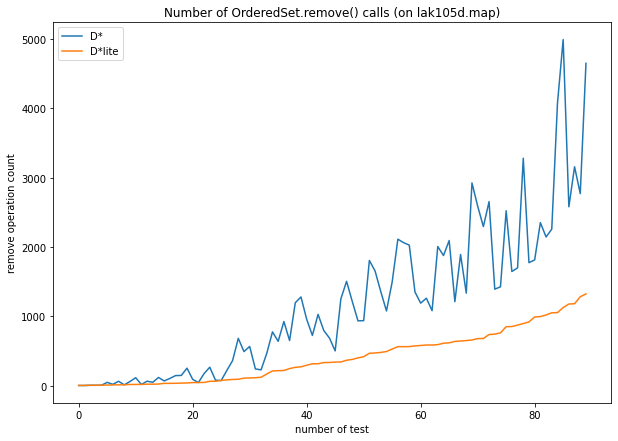

In [30]:
draw_d_star_vs_lite_heap(
    lak_ds_pop, lak_lt_pop,
    'remove operation count', 'Number of OrderedSet.remove() calls (on lak105d.map)'
)

**den312.map**

In [31]:
den_ds_add, den_ds_get, den_ds_pop = run_on(den312d_filename, den312d_scen_filename, DStar, True)
den_lt_add, den_lt_get, den_lt_pop = run_on(den312d_filename, den312d_scen_filename, DStarLite, True)

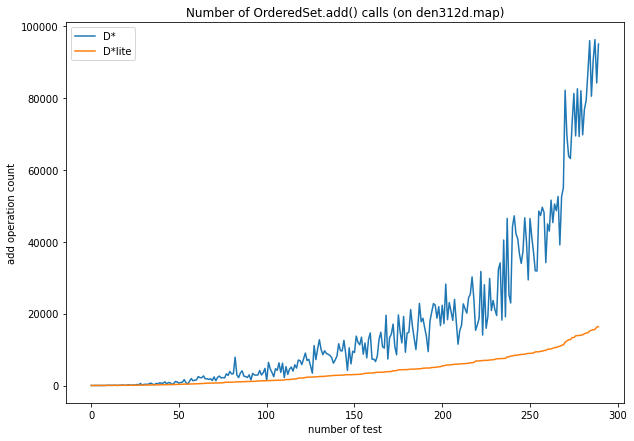

In [32]:
draw_d_star_vs_lite_heap(
    den_ds_add, den_lt_add,
    'add operation count', 'Number of OrderedSet.add() calls (on den312d.map)'
)

In [33]:
compute_diff(den_lt_pop, den_ds_pop)

0.664058250857194

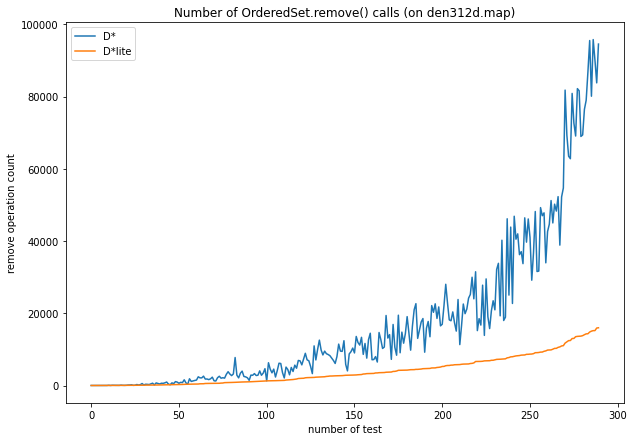

In [34]:
draw_d_star_vs_lite_heap(
    den_ds_pop, den_lt_pop,
    'remove operation count', 'Number of OrderedSet.remove() calls (on den312d.map)'
)